# Measuring Radial Velocities

In this tutorial we will learn how to derive radial velocities from a series of spectra.

We will use the cross-correlation technique to measure the velocities. You can think of this technique of sliding a model spectrum across the observed spectrum as a range of velocity shifts. At each velocity shift you multiply the model by the observed spectrum and sum up the values. When the model lines up with the observed spectrum you see a peak in this cross correlation value. The final velocity is extracted by plotting the cross correlation value as a function of velocity offset and precisely locating the peak.

In this example our 'model' will be the first spectra in a series of spectra and we will calculate the velocity shifts for each spectrum relative to the first spectrum.

In [1]:
# Import some required libraries
import numpy as np
from numpy import ma
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import pylab as pl
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

SPEED_OF_LIGHT = 2.99792e5 # Speed of light [km/s] 

In [2]:
# Here we define some functions that will be needed later for the cross correlation

def wav_to_dvel(wav):
    """Converts wavelengths to delta velocities using doppler formula"""
    dvel = (wav[1:] - wav[:-1]) / (wav[1:]) * SPEED_OF_LIGHT
    return dvel

def loglambda(wav0, flux0):
    """Resample spectrum onto a constant log-lambda wavelength scale

    Args:
        wav0 (array): array of wavelengths
        flux0 (array): flux values at wav0
    
    Returns:
        wav (array): wavelengths (constant log-spacing)
        flux (array): flux values at wav
        dvel (float): spacing between measurements in velocity space (km/s)
    """
    assert wav0.shape == flux0.shape, "wav0 and flux must be same size"
    npix = wav0.size
    wav = np.logspace(np.log10(wav0[0]), np.log10(wav0[-1]), wav0.size)
    spline = InterpolatedUnivariateSpline(wav0, flux0)
    flux = spline(wav)
    dvel = wav_to_dvel(wav)
    dvel = np.mean(dvel)
    return wav, flux, dvel


In [3]:
# Load the series of spectra into list.
# You may need to modify the path to the sample spectra.
# Each spectra file has two columns, one for wavelength and one for flux.
# We will use pandas.read_csv to load the files.

series = []
file_list = sorted(glob('../../synthetic_spectra/*.csv'))
for f in file_list:
    print(f)
    spec = pd.read_csv(f)
        
    series.append(spec)


../../synthetic_spectra/5800K+00.csv
../../synthetic_spectra/5800K+05.csv
../../synthetic_spectra/5800K+10.csv
../../synthetic_spectra/5800K+15.csv
../../synthetic_spectra/5800K+20.csv
../../synthetic_spectra/5800K-05.csv
../../synthetic_spectra/5800K-10.csv
../../synthetic_spectra/5800K-15.csv
../../synthetic_spectra/5800K-20.csv


First lets plot the first spectrum, which we will use as our 'model'

Text(0, 0.5, 'Flux [ADU]')

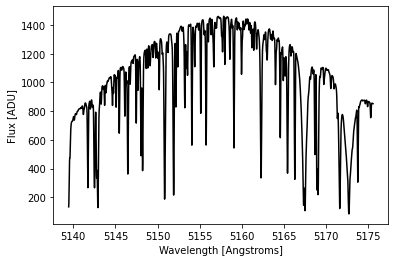

In [4]:
spec = series[0]
pl.plot(spec['wavelength'], spec['flux'], 'k-')

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')

Now we'll overplot the second spectrum in the series and zoom in on a region to visualize the offset between them.

(5150.0, 5155.0)

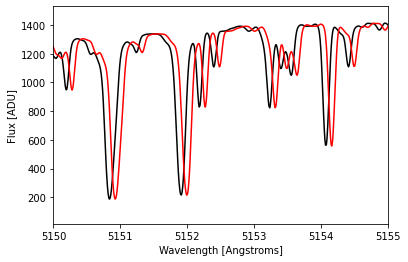

In [5]:
spec = series[0]
spec2 = series[1]
pl.plot(spec['wavelength'], spec['flux'], 'k-')
pl.plot(spec2['wavelength'], spec2['flux'], 'r-')

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')

pl.xlim(5150, 5155)

Next we will calculate the cross correlation function between our 'model' spectrum (first in the list), and the second spectrum in the list.

Text(0, 0.5, 'Cross Correlation [arbitrary units]')

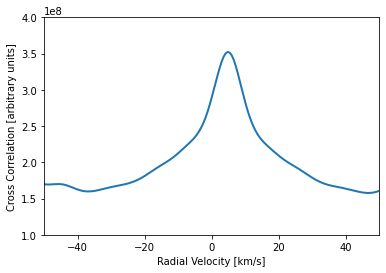

In [9]:
model = series[0]
ref_flux = model['flux'].values
ref_wav = model['wavelength'].values

spectrum = series[1]
flux = spectrum['flux'].values
wav = spectrum['wavelength'].values

nwav = flux.size

# First we need to convert target and model spectra to constant log-lambda scale
wav, flux, dvel = loglambda(wav, flux)

# Build spline object for resampling the model spectrum
ref_spline = InterpolatedUnivariateSpline(ref_wav, ref_flux)
ref_flux = ref_spline(wav)


# Perform cross-correlation.
# If `lag` is negative, the observed spectrum need to
# be blue-shifted in order to line up with the observed
# spectrum. Thus, to put the spectra on the same scale, the
# observed spectrum must be red-shifted, i.e. vmax is positive.
flux -= np.mean(flux)
ref_flux -= np.mean(ref_flux)
lag = np.arange(-nwav + 1, nwav) 
dvel = -1.0 * lag * dvel
corr = np.correlate(ref_flux, flux, mode='full')
    

# plot the cross correlation as a function of 
# velocity shift
pl.plot(dvel, corr, lw=2)
pl.xlim(-50, 50)
pl.ylim(1e8, 4e8)

pl.xlabel('Radial Velocity [km/s]')
pl.ylabel('Cross Correlation [arbitrary units]')

The peak in the cross correlation is clearly detected and indicates that spectrum 2 is redshifted by about 5 km/s relative to the first spectrum.

# Activity

1. Develop a method to precisely locate the peak of the cross correlation function above. BONUS: estimate the uncertainty of your velocities.

1. Measure the radial velocity for each spectrum in the series relative to the first spectrum and plot the series of velocities.